In [2]:
import numpy as np
import scipy.integrate as integrate
from scipy.linalg import eigvalsh_tridiagonal
from matplotlib import pyplot as plt

from IPython.display import clear_output

# Variational Principle for 1d Dirac Eigenvalues

### Some theory and notation

We are interested in the eigenvalues of the family of one-dimensional Dirac operators $(T(t))_{t\in J}$ where $J$ is some interval and 
$$ T(t)
   :=
   \begin{pmatrix}
      0 & \frac{\mathrm d}{\mathrm d x} \\
      -\frac{\mathrm d}{\mathrm d x}  & 0
   \end{pmatrix}
   +
   \begin{pmatrix}
      M_1(x,t), & W(x) \\
      W(x) & -M_2(x,t)
   \end{pmatrix},\qquad x\in \mathbb{R}.
$$
We assume that the functions $M_j, W$ satisfy:

- For all $t\in J$, the functions $x\mapsto W(x)$ and $x\mapsto M_j(x,t)$ are bounded.

- For all $t\in J$, the limits $W_\pm:=\lim_{x\to\pm\infty}W(x)$, $M_{j\pm}(t):=\lim_{x\to\pm\infty}M_j(x,t)$ exists.

- For all $t\in J$, $-m_2(t)>m_i(t)$ where $m_i(t):=\inf_{x\in \mathbb{R}}M_i(x,t)$.

- For all $x\in\mathbb{R}$, the function $t\mapsto M_1(x,t)$ is continuous and decreasing and $t\mapsto M_2(x,t)$ is continuous and increasing.

For any given $t\in J$, in the interval $[m_1(t),\lambda_{e+}(t))$ the operator $T(t)$ has the same eigenvalues (with the same multiplicities) as the operator pencil $\lambda\longmapsto S(\lambda,t)$ where

$$S(\lambda,t):=M_1(x,t)-\lambda+\left(\frac{\mathrm d}{\mathrm d x}+W(x)\right)\frac{1}{M_2(x,t)+\lambda}\left(-\frac{\mathrm d}{\mathrm d x}+W(x)\right),\qquad x\in \mathbb{R},$$
and
$$\lambda_{e+}(t):=\min\left\{ \frac{M_{1\pm}(t) - M_{2\pm}(t)}{2} + \sqrt{ \left( \frac{M_{1\pm}(t) + M_{2\pm}(t)}{2} \right)^2 + W_\pm^2}\right\}.$$

Moreover, such eigenvalues $\lambda_n(t)$ are continuous and decreasing in $t$.

### The method

Precision parameters: ``R, K, step, tolerance``

Instead of working in $\mathbb{R}$ work in $(-R,R)$ with a ordered "basis" of $K-1$ elements consisting of equidistant translations of $\phi$, which is, up to an $L_2$ normalization constant, an isosceles triangle centered at $x=0$ of height $1$ and base $2h=4 R/K$. More precisely, $\phi$ and our ordered "basis" are
$$\phi(x):=\frac{\chi_{[-h,h]}(x)}{\sqrt{2h/3}}\left(1-\frac{|x|}{h}\right),\qquad
\phi_i(x):=\phi(x - (-R + (i+1)h)),\qquad i=0,...,K-2.$$

Note that the family $\phi(x-\tau)$ for $\tau\in[-R+h,R-h]\cap\mathbb{Q}$ do form a basis of $H^1_0(-R,R).$

The advantage of this "basis" that $\phi_i,\phi_j$ have disjointed supports for $|i-j|\geq2$.

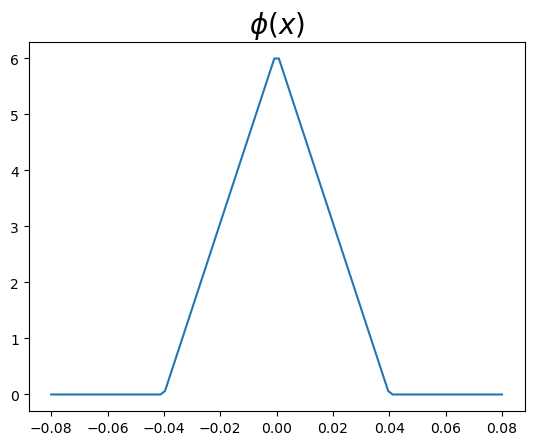

In [3]:
R = 20
K = 1000
h = 2 * R / K


def phi(x):
    return (np.abs(x) <= h) * (1 / np.sqrt(2 * h / 3)) * (-np.abs(x) + h) / h


def dphi(x):  # derivative of phi
    return (np.abs(x) <= h) * (1 / np.sqrt(2 * h / 3)) * (-np.sign(x)) / h


plt.plot(np.linspace(-2 * h, 2 * h, 100), phi(np.linspace(-2 * h, 2 * h, 100)))
plt.title(r"$\phi(x)$", fontsize=20)
plt.show()

We define the functions $M_1(x,t)$, $M_2(x,t)$, $W(x)$, and the corresponding $m_1(t)$, $\lambda_{e+}(t)$, as well as the quantity $\langle S(\lambda,t)\phi_i,\phi_j\rangle$.

In [3]:
def M1(x, t):
    return 1 - (t / 2) * np.exp(-np.abs(x))


def M2(x, t):
    return 1 + (t / 2) * np.exp(-np.abs(x))


def W(x):
    return 0


def m1(t):
    return 1 - (t / 2)


def lambde(t):
    return 1


def S(lambd, t, i, j):
    a = integrate.quad(
        lambda x: (M1(x, t) - lambd)
        * phi(x - (-R + h + i * h))
        * phi(x - (-R + h + j * h)),
        -R + i * h,
        -R + 2 * h + i * h,
    )[0]
    b = integrate.quad(
        lambda x: (1 / (M2(x, t) + lambd))
        * (-dphi(x - (-R + h + i * h)) + W(x) * phi(x - (-R + h + i * h)))
        * (-dphi(x - (-R + h + j * h)) + W(x) * phi(x - (-R + h + j * h))),
        -R + i * h,
        -R + 2 * h + i * h,
    )[0]
    return a + b

For each $(\lambda,t)$ we construct symmetric matrix associated to $S(\lambda,t)$ restricted to our "basis", which is clearly tridiagonal. If this matrix has an eigenvalue of absolute value less than ``tolerance``,  then we say that $\lambda$ is an eigenvalue of $T(t)$. We cover all possible pairs $(t,\lambda)$ using steps of size ``step``.

For the first (left-most) $t\in J$ we will run trough all possible $\lambda\in[m_1(t),\lambda_{e+}(t))$ in search for eigenvalues. However, for all subsequent $t$, knowing that the eigenvalues $\lambda_n(t)$ are continuous and decreasing in $t$, we only need to look in a neighbourhood bellow the previously found eigenvalues in addition to $\lambda_{e+}(t)$.

In [4]:
step = 0.005
tolerance = 0.005

J = np.arange(0, 4, step)  # interval for t.

T = []
Lambd = []
S_Eig = []

t = J[0]
lambd = lambde(t) - step
while lambd >= m1(t):
    clear_output(wait=True)
    print("(t, lambd) = (" + str(t) + ", " + str(lambd) + ")")
    print("len(T) = " + str(len(T)))

    d = np.array([S(lambd, t, i, i) for i in range(K - 1)])
    e = np.array([S(lambd, t, i, i + 1) for i in range(K - 2)])
    w = list(eigvalsh_tridiagonal(d, e, "v", [-tolerance, tolerance]))
    if len(w) > 0:
        T.append(t)
        Lambd.append(lambd)
        S_Eig.append(w)
    lambd -= step

for t in J[1:]:
    aux = [lambde(t) - step]
    if len(T) > 0:
        aux += [Lambd[i] for i in range(len(T)) if T[i] == T[-1]]

    neighbourhood = []
    for i in range(0, 2):
        neighbourhood += [j - i * step for j in aux]
    neighbourhood = [i for i in neighbourhood if i >= m1(t)]
    neighbourhood.sort(reverse=True)
    neighbourhood = set(neighbourhood)

    for lambd in neighbourhood:
        clear_output(wait=True)
        print("(t, lambd) = (" + str(t) + ", " + str(lambd) + ")")
        print("len(T) = " + str(len(T)))

        d = np.array([S(lambd, t, i, i) for i in range(K - 1)])
        e = np.array([S(lambd, t, i, i + 1) for i in range(K - 2)])
        w = list(eigvalsh_tridiagonal(d, e, "v", [-tolerance, tolerance]))
        if len(w) > 0:
            T.append(t)
            Lambd.append(lambd)
            S_Eig.append(w)

(t, lambd) = (3.995, 0.024999999999999183)
len(T) = 1785


We graph!

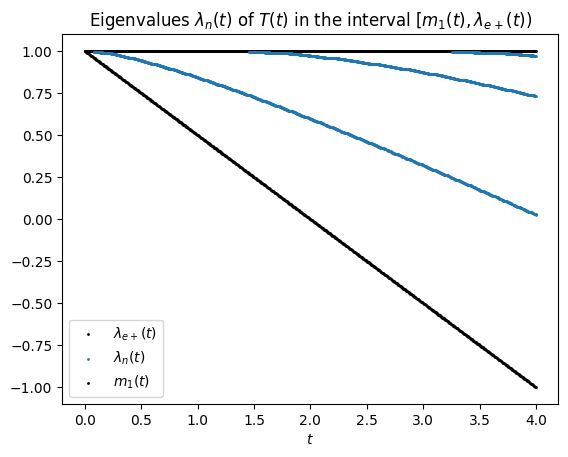

In [6]:
# if tolerance is to high we might get thick lines, we can make it smaller here
index = [i for i in range(len(T)) if any(np.abs(np.array(S_Eig[i])) < 1 * tolerance)]

# plt.scatter(J, lambde(J), s=1, color="black", label=r"$\lambda_{e+}(t)$")
plt.scatter(J, np.full(len(J), 1), s=1, color="black", label=r"$\lambda_{e+}(t)$")
plt.scatter(
    [T[i] for i in index], [Lambd[i] for i in index], s=1, label=r"$\lambda_n(t)$"
)
plt.scatter(J, m1(J), s=1, color="black", label=r"$m_1(t)$")
plt.legend()
plt.xlabel(r"$t$")
plt.title(
    r"Eigenvalues $\lambda_n(t)$ of $T(t)$ in the interval $[m_1(t),\lambda_{e+}(t))$"
)
plt.show()

And then save.

In [7]:
import json

header = "t,lambda"
np.savetxt(
    "(t,lambda).csv",
    np.column_stack((T, Lambd)),
    delimiter=",",
    header=header,
)

with open("S_Eig.json", "w") as f:
    json.dump(S_Eig, f, indent=2)